# Determining the age of customers

## Exploratory data analysis

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


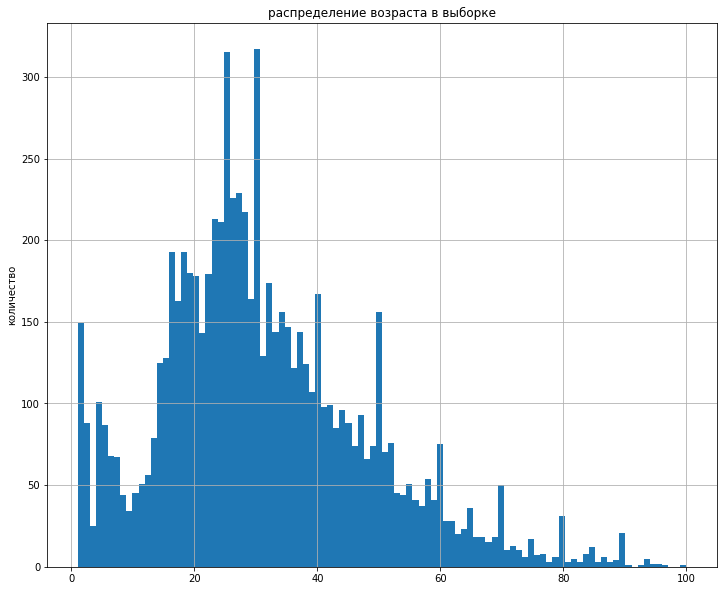

In [5]:
labels.hist(bins = 100, figsize = (12,10))
plt.title('распределение возраста в выборке')
plt.ylabel('количество')
plt.show()

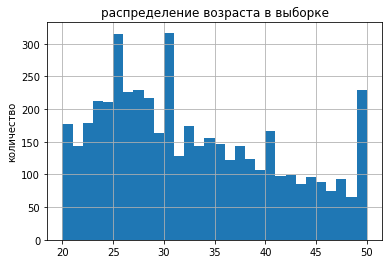

In [6]:
labels.hist(bins = 30, range = [20,50])
plt.title('распределение возраста в выборке')
plt.ylabel('количество')
plt.show()

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
def show_photo(train_gen_flow, num):
    fig = plt.figure(figsize=(10,10))
    for i in range(num):
        fig.add_subplot(4, 4, i+1)
        image = Image.open('/datasets/faces/final_files/{:s}'.format(labels.iloc[i,0]))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.title('Возраст: ' + str(labels['real_age'].iloc[i]))
plt.show()

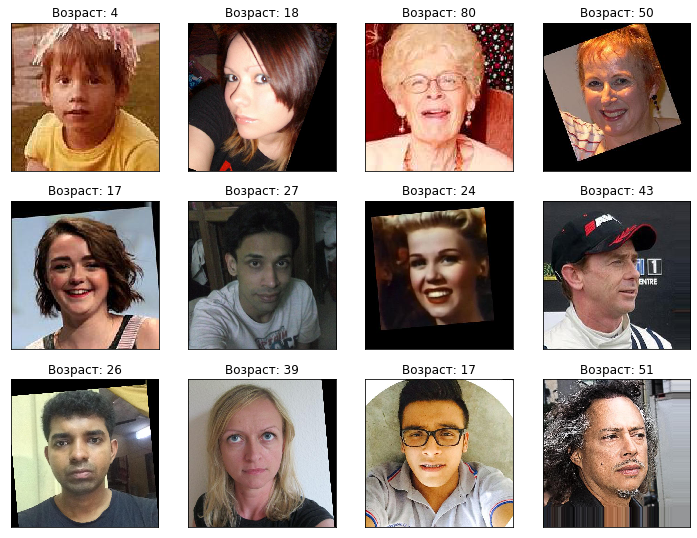

In [9]:
show_photo(train_gen_flow,12)

We have a set of 7591 photos, the sample is not large, to increase the accuracy of the predictions we apply augmentation - horizontal reflection. The size of the array is 224x224x3.  
On the photos there are portraits of people from 1 to 100 years old. The majority of the photos belong to people aged 20 to 40.
There are headgear and glasses in the photos, the photos were taken from different angles, there are black and white and color photos, the lightness and quality of the images also varies. Judging by the images we are dealing with prepared photographs - the oval of the face is in the center of the picture and is horizontal, the space left after the centering is filled with black on the edges of the processed pictures. Foreign objects in the frame will make it difficult to learn the model.   
The histogram shows peaks in round dates (25, 30, 40, 50, 60, 70, 80, 90). This feature may be connected with a rounding error or human factor, i.e. it is more convenient for people to report a round date rather than specify an exact age.  



## Model training

The code in this section is run in a separate GPU engine, so it is not designed as a code cell, but as code in a text cell.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=16,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model


```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/16
2021-09-13 07:41:46.327540: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-13 07:41:46.651603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 244.3385 - mae: 11.1372 - val_loss: 1022.9283 - val_mae: 27.3086
Epoch 2/16
178/178 - 38s - loss: 78.9481 - mae: 6.7141 - val_loss: 978.9001 - val_mae: 26.5789
Epoch 3/16
178/178 - 38s - loss: 49.5249 - mae: 5.3936 - val_loss: 605.4087 - val_mae: 19.7704
Epoch 4/16
178/178 - 38s - loss: 36.7906 - mae: 4.6158 - val_loss: 138.7659 - val_mae: 8.7878
Epoch 5/16
178/178 - 38s - loss: 26.7901 - mae: 3.9138 - val_loss: 76.2468 - val_mae: 6.5540
Epoch 6/16
178/178 - 38s - loss: 21.7913 - mae: 3.5790 - val_loss: 71.0659 - val_mae: 6.3511
Epoch 7/16
178/178 - 38s - loss: 17.8266 - mae: 3.2288 - val_loss: 87.1539 - val_mae: 7.2373
Epoch 8/16
178/178 - 38s - loss: 13.7522 - mae: 2.8625 - val_loss: 63.7662 - val_mae: 5.8852
Epoch 9/16
178/178 - 38s - loss: 12.3907 - mae: 2.6843 - val_loss: 65.2720 - val_mae: 6.0975
Epoch 10/16
178/178 - 39s - loss: 10.4917 - mae: 2.4613 - val_loss: 64.4102 - val_mae: 6.0622
Epoch 11/16
178/178 - 39s - loss: 9.5559 - mae: 2.3541 - val_loss: 66.0273 - val_mae: 6.1730
Epoch 12/16
178/178 - 39s - loss: 8.8727 - mae: 2.2175 - val_loss: 65.7995 - val_mae: 6.0177
Epoch 13/16
178/178 - 39s - loss: 8.5330 - mae: 2.1981 - val_loss: 64.2802 - val_mae: 6.0370
Epoch 14/16
178/178 - 39s - loss: 8.2564 - mae: 2.1953 - val_loss: 67.9232 - val_mae: 6.3196
Epoch 15/16
178/178 - 39s - loss: 7.5108 - mae: 2.0796 - val_loss: 62.3498 - val_mae: 6.0516
Epoch 16/16
178/178 - 39s - loss: 6.6695 - mae: 1.9729 - val_loss: 61.9988 - val_mae: 5.7958
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 61.9988 - mae: 5.7958
Test MAE: 5.7958


```

## Analysis of the trained model

With the help of ImageNet ResNet pre-trained from 50 layers the model was trained. The following settings were used during training: Batches size = 32, Adam optimizer with learning rate 0.0001, number of epochs 16, loss function - `mean_squared_error`, activation function on the fully connected layer - relu. The average error in the test sample was `MAE = 5.79`.  Thus, the model in determining the age from the photograph, on average, makes an error of 5.8 years.